## Imports 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import numpy as np
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import MaxPooling2D
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Conv2D, Flatten, MaxPooling2D
import tensorflow as tf
import cv2
import pathlib
from keras import applications
from tensorflow.keras.layers import InputLayer
from keras.layers import Dense, GlobalAveragePooling2D
import os
import IPython.display as display
from PIL import Image

import glob # To return the file names in each dir

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Data 


Convert .seq and .vbb to .jpg and .pkl


In [81]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
data_dir = '/content/drive/Shared drives/CSCE421 - ENDProject/Datasets'
data_dir = pathlib.Path(data_dir)

print(data_dir)

CLASS_NAMES = np.array(['Bikes','Cars', 'Pedestrians'])

image_count = len(list(data_dir.glob(('*/*.jpg'))))  + len(list(data_dir.glob(('*/*.JPG')))) 
print('Image count: ', image_count)




/content/drive/Shared drives/CSCE421 - ENDProject/Datasets
Image count:  1524


###(a) Motivation and Data

Our problem is to classify traffic camera images based on how many pedestrians, cars, and cyclists there are. This is a supervised machine learning problem, the input are images and the output is the class associated with the image (person, car, bike). 

###Preprocessing 

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [85]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(3):
  print(f.numpy())

b'/content/drive/Shared drives/CSCE421 - ENDProject/Datasets/Cars/1837173923.jpg'
b'/content/drive/Shared drives/CSCE421 - ENDProject/Datasets/Bikes/43139719_f87fe09393.jpg'
b'/content/drive/Shared drives/CSCE421 - ENDProject/Datasets/Bikes/1324145880_8d8013faf2.jpg'


In [86]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
for image, label in labeled_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())


def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()

  ds = ds.shuffle(buffer_size=shuffle_buffer_size)

  # Repeat forever
  ds = ds.repeat()

  ds = ds.batch(BATCH_SIZE)

  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=AUTOTUNE)

  return ds



Image shape:  (224, 224, 3)
Label:  [ True False False]


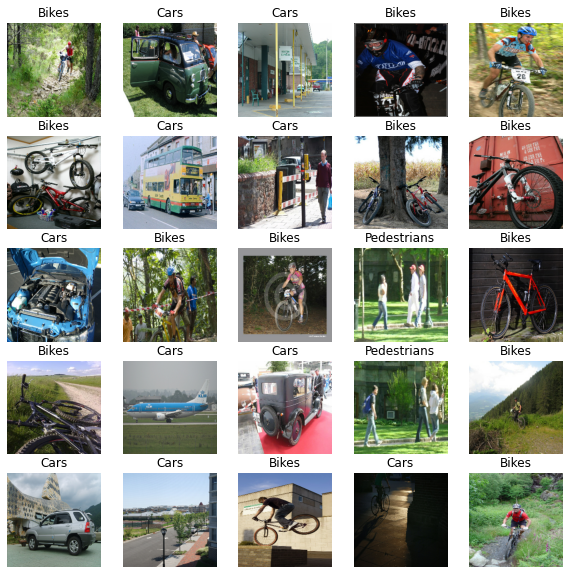

In [87]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

###Test Data


In [0]:


# train_dataset = train_ds.take(train_size)
# test_dataset = train_ds.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)

train_dataset = train_ds.take(train_size)
test_dataset = train_ds.skip(train_size)
val_dataset = test_dataset.skip(val_size)
test_dataset = test_dataset.take(test_size)

# Model

In [0]:
# Convolution layers of vgg16
vgg_model = applications.VGG16(weights='imagenet',
                               include_top=False,
                               input_shape=(IMG_HEIGHT,IMG_WIDTH,3)) 
for layer in vgg_model.layers:
    layer.trainable = False

layer_dict = dict([(layer.name, layer) for layer in vgg_model.layers])


###Feature Extraction

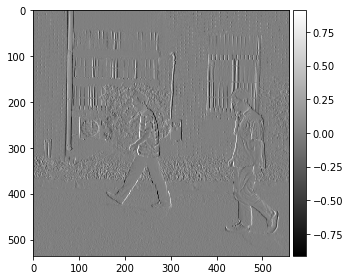

In [107]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
img_path = "/content/drive/Shared drives/CSCE421 - ENDProject/Datasets" + '/Pedestrians/image1.jpg'
image = imread(img_path, as_gray=True)
edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(image)
imshow(edges_prewitt_vertical, cmap='gray')


In [92]:
# Create custom model with layers on top
x = vgg_model.output
# GlobalAveragePooling will flatten the dimensions 
x = GlobalAveragePooling2D()(x)
#  fully connected layers
x = Dense(1024, activation='relu')(x)

# Last layer for the three classes (Person, bike, car)
predictions = Dense(3, activation='softmax')(x)
from keras.models import Model
custom_model = Model(input=vgg_model.input, output=predictions)
print(custom_model.summary())

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.


In [0]:
base_learning_rate = 0.0001
custom_model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [76]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_datasets as tfds
checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, 
                            save_best_only=True, save_weights_only=False, 
                             mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, 
                      mode='auto')
hist = custom_model.fit_generator(steps_per_epoch=STEPS_PER_EPOCH,
                                  generator=iter(train_dataset), 
                           validation_data= iter(val_dataset), 
                           validation_steps=10,
                           epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
48/48 [==============================] - 7s 144ms/step - loss: 0.7068 - accuracy: 0.6634 - val_loss: 0.6797 - val_accuracy: 0.7625

Epoch 00001: val_accuracy improved from -inf to 0.76250, saving model to vgg16_1.h5
Epoch 2/100
 2/48 [>.............................] - ETA: 3s - loss: 0.6792 - accuracy: 0.7812

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


48/48 [==============================] - 5s 100ms/step - loss: 0.6649 - accuracy: 0.7793 - val_loss: 0.6682 - val_accuracy: 0.8250

Epoch 00002: val_accuracy improved from 0.76250 to 0.82500, saving model to vgg16_1.h5
Epoch 3/100
48/48 [==============================] - 5s 100ms/step - loss: 0.6504 - accuracy: 0.7897 - val_loss: 0.6474 - val_accuracy: 0.7656

Epoch 00003: val_accuracy did not improve from 0.82500
Epoch 4/100
48/48 [==============================] - 5s 100ms/step - loss: 0.6438 - accuracy: 0.7962 - val_loss: 0.6297 - val_accuracy: 0.8062

Epoch 00004: val_accuracy did not improve from 0.82500
Epoch 5/100
48/48 [==============================] - 5s 99ms/step - loss: 0.6384 - accuracy: 0.8079 - val_loss: 0.6184 - val_accuracy: 0.7969

Epoch 00005: val_accuracy did not improve from 0.82500
Epoch 6/100
48/48 [==============================] - 5s 99ms/step - loss: 0.6361 - accuracy: 0.8086 - val_loss: 0.6315 - val_accuracy: 0.8375

Epoch 00006: val_accuracy improved from 0.

StopIteration: ignored

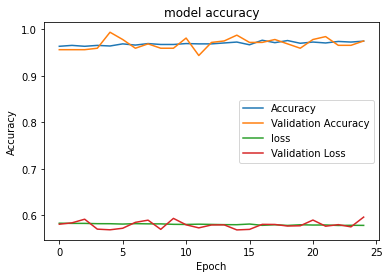

In [78]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

# Testing